# copy trianing code from the sharing_code file without normalization data before neural network

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 5000/5000 [1:31:13<00:00,  1.09s/it, train Loss=0.05277865, test loss=0.050607823]   


r2:0.9398038983345032,mse : 0.05060780793428421, l2_rel : 0.24193337559700012


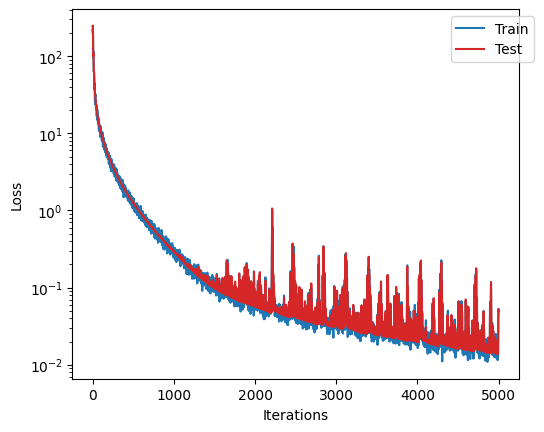

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        
        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
        # print("Denominator shape:", denominator.shape)

        # Expand the denominator to match the shape of s_hat (28, 28, 1)
        denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
        # print("Denominator shape after expansion:", denominator.shape)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        # print("Shape of s_hat (after fft2):", s_hat.shape)

        v_hat = s_hat / denominator  # Now shapes should match
        # print("Shape of v_hat (after division):", v_hat.shape)

        uk = jfft.ifft2(v_hat)  # inverse FFT
        # print("Shape of uk (after ifft2):", uk.shape)

        uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
        # print("Shape of uk after reshaping:", uk.shape)

        # Return the real part
        return jnp.real(uk)  # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
        u_ac = self.allen_cahn_equation(uk)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
       
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, dataset, data_test, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)  # Progress bar for total iterations


        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                loss_test = self.loss_batches(params, data_test)
                self.train_losses.append(loss)
                self.test_losses.append(loss_test)
                pbar.set_postfix({'train Loss': loss, 'test loss': loss_test})


    def pred(self, data_test):
        uk_solver_list = []
        uk_nnetwork_list = []
        

        for item in data_test:

            uk = self.allen_cahn_equation(item)
            # cahn = eps**2
            # uk = jnp.real(item)
           

            # # Compute denominator in Fourier space
            # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # # Perform FFT calculations
            # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            # v_hat = s_hat / denominator  
            # uk_ac = jfft.ifft2(v_hat)  
            uk_ac = uk.reshape(self.N, self.N, 1)
            uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(uk_solver, (uk_solver.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_solver, uk_nnetwork


    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
# print(f'pp2 shape:{pp2.shape}')
# print(f'qq2 shape:{qq2.shape}')




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 5000

data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
# normalized_data, min_val, range_val = normalize(data) 
# Generate the data trainig samples
dataset = DataGenerator(data[:9800], batch_size=20)
data_test = data[9899:]




#    # Initialize and train the model
NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
NN_model.train(dataset, data_test, nIter = epochs)
r2, mse, l2_rel, u_solver, u_pred = NN_model.pred(data_test)
print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')

NN_model.plot_losses(f'plots/training_log_iter_{epochs}.png')


import pickle
# saving the parameter
def save_model(model, filename):
    # Save model parameters, architecture and optimizer state
    save_dict = {
        'arch': model.arch,
        'N': model.N,
        'lr': model.lr,
        'eps': model.eps,
        'pp2': model.pp2,
        'qq2': model.qq2,
        'dt': model.dt,
        'L': model.L,
        'h': model.h,
        'x': model.x,
        'y': model.y,
        'params': jax.device_get(model.get_params(model.opt_state)),
        'train_losses': model.train_losses,
        'test_losses': model.test_losses,
        'opt_state': jax.device_get(model.opt_state),  # Save optimizer state too
    }

    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)


save_model(NN_model, f'models/savemodel_{epochs}.pkl')

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
import pickle






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        
        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
        # print("Denominator shape:", denominator.shape)

        # Expand the denominator to match the shape of s_hat (28, 28, 1)
        denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
        print("Denominator shape after expansion:", denominator.shape)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        # print("Shape of s_hat (after fft2):", s_hat.shape)

        v_hat = s_hat / denominator  # Now shapes should match
        # print("Shape of v_hat (after division):", v_hat.shape)

        uk = jfft.ifft2(v_hat)  # inverse FFT
        # print("Shape of uk (after ifft2):", uk.shape)

        uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
        # print("Shape of uk after reshaping:", uk.shape)

        # Return the real part
        return jnp.real(uk)  # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
        u_ac = self.allen_cahn_equation(uk)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
       
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, dataset, data_test, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)  # Progress bar for total iterations


        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                loss_test = self.loss_batches(params, data_test)
                self.train_losses.append(loss)
                self.test_losses.append(loss_test)
                pbar.set_postfix({'train Loss': loss, 'test loss': loss_test})


    def pred(self, data_test):
        uk_solver_list = []
        uk_nnetwork_list = []
        

        for item in data_test:

            uk = self.allen_cahn_equation(item)
            # cahn = eps**2
            # uk = jnp.real(item)
           

            # # Compute denominator in Fourier space
            # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # # Perform FFT calculations
            # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            # v_hat = s_hat / denominator  
            # uk_ac = jfft.ifft2(v_hat)  
            uk_ac = uk.reshape(self.N, self.N, 1)
            uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(uk_solver, (uk_solver.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_solver, uk_nnetwork


    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
# print(f'pp2 shape:{pp2.shape}')
# print(f'qq2 shape:{qq2.shape}')




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 5


def load_model(filename):
    # Load the saved model data
    with open(filename, 'rb') as f:
        save_dict = pickle.load(f)

    # Reconstruct the model based on the saved architecture type
    arch = save_dict['arch']
    N = save_dict['N']
    lr = save_dict['lr']
    eps = save_dict['eps']
    pp2 = save_dict['pp2']
    qq2 = save_dict['qq2']
    dt = save_dict['dt']
    L = save_dict['L']
    h = save_dict['h']
    x = save_dict['x']
    y = save_dict['y']

    # Reconstruct architecture layers (FNO, MLP, etc.)
    if arch == 'FNO':
        fno_layers = [
            Dense(64),
            Permute("ijkl->iljk"),
            FNOBlock2D(15),
            Gelu,
            FNOBlock2D(15),
            Gelu,
            FNOBlock2D(15),
            Permute("ijkl->iklj"),
            Dense(128),
            Gelu,
            Dense(1),
        ]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, [], lr, arch)

    elif arch == 'MLP':
        mlp_layers = [16384, 32, 32, 16384]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)

    elif arch == 'modified_MLP':
        mlp_layers = [16384, 32, 32, 16384]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)
    else:
        raise ValueError(f"Unsupported architecture {arch}")

    # Restore model parameters and optimizer state
    model.params = save_dict['params']
    model.opt_state = save_dict['opt_state']
    model.train_losses = save_dict['train_losses']
    model.test_losses = save_dict['test_losses']
    
    return model


data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
# normalized_data, min_val, range_val = normalize(data) 
# Generate the data trainig samples
# dataset = DataGenerator(data[:9800], batch_size=20)
data_test = data[9800:]




#    # Initialize and train the model
# NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
loaded_model = load_model('models/savemodel_5000.pkl')
# NN_model.train(dataset, data_test, nIter = epochs)
r2, mse, l2_rel, u_solver, u_pred = loaded_model.pred(data_test)
print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')





Denominator shape after expansion: (28, 28, 1)
r2:0.9391257762908936,mse : 0.05070889741182327, l2_rel : 0.24504025280475616
